**DSCI Group 6 Final Project: Report**

By Brady Bracken, Ally Davies, Eric Zhang, Louis Ryu

**Introduction:**
Pokemon is an international video game franchise that has been popular for many years. The creatures found in the Pokemon games, called Pokemon, each have their own unique properties. There are 1032 unique Pokemon across all current games. They have basic definitions such as their Type, stats (HP, Attack, Special Attack, Defense, Special Defense, Speed), and whether or not they are a final evolution. 

We want to use classification to predict whether a pokemon is a final evolution or not using BST (Base Stat Total). 

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


**Section 1: Preliminary exploratory data analysis:**

Below, we have read our Pokemon dataset (Source: https://www.kaggle.com/datasets/maca11/all-pokemon-dataset/data) into R, selecting only the columns we deem important. 

Those being,

- Name: Name of the Pokemon
- Type 1: The Pokemon's Primary type (we won't include secondary types in this)
- HP: The Pokemon's Base HP (Hit Points)
- Att: The Pokemon's Base Attack
- Def: The Pokemon's base defense
- Spa: The Pokemon's Base special attack
- Spd: The Pokemon's Base special defense
- Spe: The Pokemon's Base speed
- BST: The Total of the above 6 values, or Base Stat Total
- Mean: The average of all Base Stats
- Standard Deviation: Standard deviation of all base stats
- Generation: Generation it was introduced
- Final Evolution: 1 = Pokemon is a final evolution
                 0 = Pokemon is not a final Evolution
- Catch Rate: The catch rate, the higher the number, the harder it is to catch with a Poke Ball.
- Legendary: 1 = Pokemon is a Legendary
           0 = Pokemon is not a Legendary
- Mega Evolution: 1 = Pokemon is a Mega Evolution
                0 = Pokemon is not a Mega Evolution
- Height: The Pokemon's height
- Weight: The Pokemon's weight
- BMI: The Pokemon's BMI

In [13]:
## Run this cell first to download the database that we are interested in.
url <- 'https://raw.githubusercontent.com/bradyb2005/dsci-100-group-6/main/data/All_Pokemon.csv'
download.file(url, destfile = "data/All_Pokemon.csv")


In [14]:
## Run this cell to view the data, using only the variables listed above.
## We may not use all of this data, however we have listed all variables that may be useful.
## Table is ordered by the Pokemon's order of appearance (eg. Pokedex number)
pokemon_data <- read_csv("data/All_Pokemon.csv")
pokemon_data_selected <- select(pokemon_data, Name, `Type 1`, HP, Att, Def, Spa, Spd, Spe, BST, Mean,  `Standard Deviation`,
                                Generation, `Final Evolution`,  `Catch Rate`, Legendary, `Mega Evolution`, Height, Weight, BMI)
pokemon_data_selected
## Note: All data is already scaled and cleaned.

Rows: 1032 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Name, Type 1, Type 2, Abilities, Experience type
dbl (39): Number, HP, Att, Def, Spa, Spd, Spe, BST, Mean, Standard Deviation...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Type 1,HP,Att,Def,Spa,Spd,Spe,BST,Mean,Standard Deviation,Generation,Final Evolution,Catch Rate,Legendary,Mega Evolution,Height,Weight,BMI
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bulbasaur,Grass,45,49,49,65,65,45,318,53.0,8.640988,1,0,45,0,0,0.7,6.9,14.1
Ivysaur,Grass,60,62,63,80,80,60,405,67.5,8.902247,1,0,45,0,0,1.0,13.0,13.0
Venusaur,Grass,80,82,83,100,100,80,525,87.5,8.902247,1,1,45,0,0,2.0,100.0,25.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Calyrex,Psychic,100,80,80,80,80,80,500,83.33333,7.45356,8,1,3,1,0,1.1,7.7,6.4
Calyrex Ice Rider,Psychic,100,165,150,85,130,50,680,113.33333,39.33475,8,1,3,1,0,2.4,809.1,140.5
Calyrex Shadow Rider,Psychic,100,85,80,165,100,150,680,113.33333,32.36081,8,1,3,1,0,2.4,53.6,9.3


Below here we selected the 'Name' 'Type 1' 'Attack' 'Bst' and 'Final Evolition' column since we are focus on them. After that we scale and center 'BST' and 'Attack' variables of the pokemon dataset and save them as columns in our data table.

In [15]:
pokemon_data_1 <- read_csv("data/All_Pokemon.csv")
pokemon_data_selected_1 <- select(pokemon_data, Name, `Type 1`,Att, BST,  
                                 `Final Evolution`) |> mutate(scaled_BST = scale(BST, center = TRUE),
                                                             scaled_Att = scale(Att, center = TRUE))
pokemon_data_selected_1

Rows: 1032 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Name, Type 1, Type 2, Abilities, Experience type
dbl (39): Number, HP, Att, Def, Spa, Spd, Spe, BST, Mean, Standard Deviation...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Type 1,Att,BST,Final Evolution,scaled_BST,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
Bulbasaur,Grass,49,318,0,-0.9997739,-0.96877268
Ivysaur,Grass,62,405,0,-0.2788324,-0.56929352
Venusaur,Grass,82,525,1,0.7155695,0.04528979
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Calyrex,Psychic,80,500,1,0.5084025,-0.01616854
Calyrex Ice Rider,Psychic,165,680,1,2.0000054,2.59581053
Calyrex Shadow Rider,Psychic,85,680,1,2.0000054,0.13747728


**Table Analysis**

Below we will be partitioning pokemon_data into a training (75%) and testing (25%) set using the tidymodels package. After that, we will summarize the average BST for each Pokemon Type in our training set only. We will do so with all pokemon (Table 1), and only pokemon who are a final evolution (Table 2).

In [18]:
# Set the seed. Don't remove this!
set.seed(39) 

# Randomly take 75% of the data in the training set. 

pokemon_split <- initial_split(pokemon_data_selected_1, prop = 0.75, strata = Name)  
pokemon_train <- training(pokemon_split)   
pokemon_test <- testing(pokemon_split)

pokemon_train
pokemon_test

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Name,Type 1,Att,BST,Final Evolution,scaled_BST,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
Bulbasaur,Grass,49,318,0,-0.9997739,-0.96877268
Ivysaur,Grass,62,405,0,-0.2788324,-0.56929352
Venusaur,Grass,82,525,1,0.7155695,0.04528979
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Calyrex,Psychic,80,500,1,0.5084025,-0.01616854
Calyrex Ice Rider,Psychic,165,680,1,2.0000054,2.59581053
Calyrex Shadow Rider,Psychic,85,680,1,2.0000054,0.13747728


Name,Type 1,Att,BST,Final Evolution,scaled_BST,scaled_Att
<chr>,<chr>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
Mega Charizard X,Fire,130,634,1,1.6188180,1.520290
Butterfree,Bug,45,395,1,-0.3616993,-1.091689
Mega Beedrill,Bug,150,495,1,0.4669690,2.134873
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Dragapult,Dragon,120,600,1,1.337071,1.212998
Glastrier,Ice,145,580,1,1.171337,1.981227
Spectrier,Ghost,65,580,1,1.171337,-0.477106


In [19]:
## First dataset is taking the average BST per Type.
bst_data <- pokemon_train |>
            group_by(`Type 1`) |>
            summarize(BST_avg = mean(BST))
bst_data

## Second dataset is taking the average BST per Type, but only for a final evolution.
bst_data_final <- pokemon_train |>
            filter(`Final Evolution` == 1) |>
             group_by(`Type 1`) |>
            summarize(BST_avg = mean(BST))
bst_data_final

Type 1,BST_avg
<chr>,<dbl>
Bug,392.9000
Dark,430.4571
Dragon,533.8667
⋮,⋮
Rock,446.0789
Steel,491.4286
Water,432.6100


Type 1,BST_avg
<chr>,<dbl>
Bug,488.1613
Dark,507.8000
Dragon,627.2000
⋮,⋮
Rock,517.8000
Steel,547.2222
Water,514.6491


When observing the tables above, we can clearly see that the BST average is much higher among Pokemon that are the Final Evolution compared to pokemon on average.

**Plot Analysis**

To further prove that a Pokemon's BST is much higher for a Final Evolution compared to a Pokemon that is not a Final Evolution, the scatter plot below will plot the relationship between Attack and BST for all Pokemon (the Attack Stat isn't relevant here, any Base Stat would work for this graph), coloring Pokemon that are a final evolution in blue and a pokemon that is not a final evolution black.

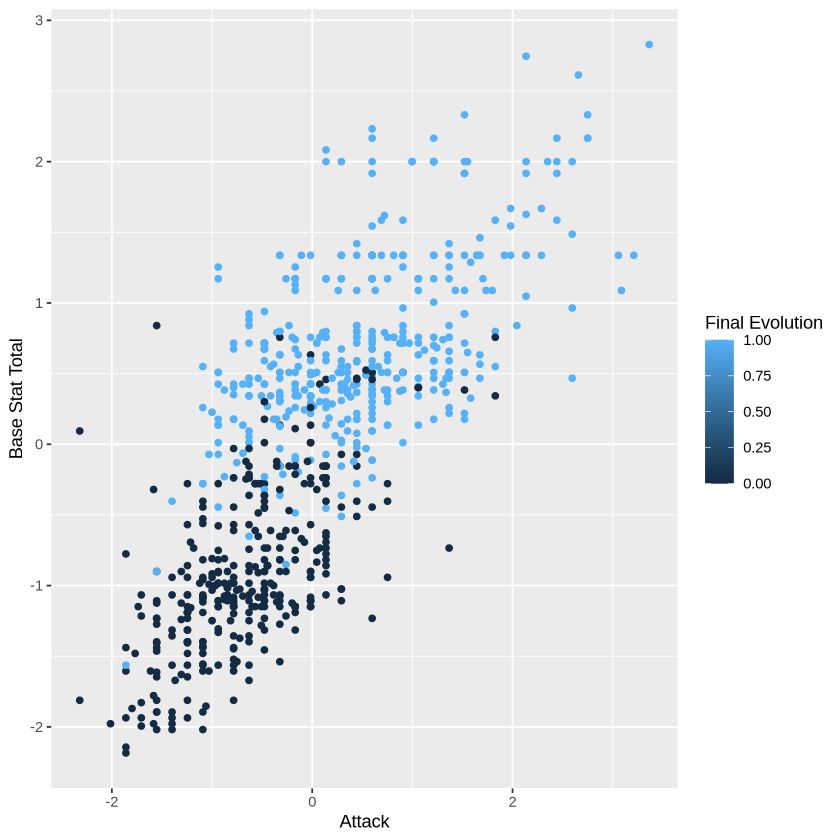

In [21]:
## this scatterplot will plot a Pokemon's Attack on the x-axis and the BST on the y-axis, 
## coloring Final Evolutions as blue and not Final Evolutions as black.
capture_data <- pokemon_train |>
    ggplot(aes(x = scaled_Att, y = scaled_BST, color = `Final Evolution`)) +
    geom_point() +
    labs(x= "Attack", y = "Base Stat Total")
capture_data

Observing the plot above, we can clearly see that Pokemon who are a final evolution have a significant increase in BST compared to Pokemon who aren't the final evolution.

**Section 2: Methods**

We plan to use classification to predict whether a Pokemon is a final evolution or not using k-nearest-neighbors. We will use Scaled_BST and Scaled_Attack (any base stat would work for this prediction) as our predictive variables.

One way we could visualize our results is very similar to the scatter plot we showed above. We create a plot chart, and we use the k-nearest-neighbors method to predict the outcome we want to know, and we compare our observations of the graph with the output of the k-neighbors method to get the conclusion of our observations.

**Section 3: Outcomes and Significance**

(insert what do you expect to find)
We expect to find the relationship between BST,Attack, and final evolution status. This will show if there is a trend for final evolutions to have different BST and Attack scores, and how they could be used to determine a final evolution status of an unknown pokemon.


(insert what impact could such findings have)
This would allow pokemon to be identified and classified with limited information, and also give game devolopers an easier time creating pokemon as they can come up with stats and be told the final evolution status.

(insert what future questions this could lead to)
This data analysis could lead to future questions such as:

What does the final evolution status look like divided by pokemon type?

Do different types have different BST and attack scores that could be used to determine not only evolution status, but also tye?

What components of BST have the biggest impact on the score and final evolution status?
